In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import NMF
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, DepthwiseConv2D, GlobalAvgPool2D

2025-07-23 12:25:57.032274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#FUNCTIONS    
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (128,128))
    # Scale image to be between 0 and 1 
    # img = img.numpy()
    img = img / 255.0

    # H, W, C = img.shape                      # (100, 100, 3) 255.0     # non-negative
    # X = img.reshape(H, W * C)    
    #             # → (100, 300)   2-D, non-negative
    # nmf = NMF(n_components=60, init="nndsvda", max_iter=200)
    # Ww = nmf.fit_transform(X)                 # (100, 50)
    # Hmat = nmf.components_                   # (50, 300)
 
    # # low-rank reconstruction back to image
    # img_lowrank = Ww @ Hmat
    # img_lowrank = img_lowrank.reshape(H, W, C) 
    # img_back = tf.convert_to_tensor(img_lowrank, dtype=tf.float32)   # ► NumPy → Tensor

    # Return image
    return img

def flip(image):
    image

    flipped=[]
    for r in range(len(image[:])):
        row=[]
        for i in range(len(image[r])):
            row.append(image[-r][-i])
        flipped.append(row)
    return flipped

def reduce(image,amount):

    reduced=[]

    #we pick out only a select number of the pixels from the image.


    row_list=np.linspace(0,len(image[:]),int((len(image[:]))/ amount ))
    row_indexes=[]
    for i in range(len(row_list)):
        row_indexes.append(int(row_list[i]))


    column_list=np.linspace(0,len(image[0]),int((len(image[0]))/ amount ))
    column_indexes=[]
    for i in range(len(column_list)):
        column_indexes.append(int(column_list[i]))


    for r in range(len(image[:])):
    
        if r in row_indexes:
        
            row=[]
            for i in range(len(image[r])):
                if i in column_indexes:
                    row.append(image[r][i])

    
            reduced.append(row)
    return reduced


DATASET=os.listdir('DATASET/train')

SET=[]
for j in range(len(DATASET)):
    person=DATASET[j]
    folder=os.listdir('DATASET/train/' + person)

    image_list= []
    for i in range(len(folder)):
        image_list.append(preprocess('DATASET/train/' + person + '/' + folder[i]))
    SET.append(image_list)

In [3]:
# SET LOFT FOR GPU
#We want to avoid out-of-memory errors by creating a sealing to GPU usage

gpus = tf.config.experimental.list_physical_devices('GPU') #defining/naming my gpu in python
 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) #setting a loft on it so it doesn't go crazy with memory, leading to oom errors

for directory in os.list.dir('DATASET/train'):
    for file in os.listdir('DATASET/train', directory):
        EX_PATH=os.path.join('DATASET/train',directory, file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [4]:
def make_pairs_specific_person(class_to_imgs, target_person_name1, target_person_name2, target_person_name3,n_pos=100, n_neg_total=10000, seed=None):
    """
    Builds pairs where positives are only from the target_person_name.
    """
    rng = random.Random(seed)
    classes = list(class_to_imgs.keys())

    posval, posanch = [], []
    negval, neganch = [], []

    # --- MODIFIED POSITIVE PAIR LOGIC ---
    # Check if the target person exists and has enough images
    if target_person_name1 in class_to_imgs and len(class_to_imgs[target_person_name1]) >= 2:
        imgs = class_to_imgs[target_person_name1]
        for _ in range(n_pos):
            # Sample two different images from the target person
            a, b = rng.sample(imgs, 2)
            posval.append(a)
            posanch.append(b)

    if target_person_name2 in class_to_imgs and len(class_to_imgs[target_person_name2]) >= 2:
        imgs = class_to_imgs[target_person_name2]
        for _ in range(n_pos):
            # Sample two different images from the target person
            a, b = rng.sample(imgs, 2)
            posval.append(a)
            posanch.append(b)   

    if target_person_name3 in class_to_imgs and len(class_to_imgs[target_person_name3]) >= 2:
        imgs = class_to_imgs[target_person_name3]
        for _ in range(n_pos):
            # Sample two different images from the target person
            a, b = rng.sample(imgs, 2)
            posval.append(a)
            posanch.append(b) 

    # negatives
    for _ in range(n_neg_total):
        c1, c2 = rng.sample(classes, 2)           # two different people
        negval.append(rng.choice(class_to_imgs[c1]))
        neganch.append(rng.choice(class_to_imgs[c2]))
        

    return tf.data.Dataset.from_tensor_slices(posval), tf.data.Dataset.from_tensor_slices(negval), tf.data.Dataset.from_tensor_slices(posanch), tf.data.Dataset.from_tensor_slices(neganch)

import random
import tensorflow as tf

def make_pairs_from_folders(class_to_imgs, num_folders=50, n_pos_per_folder=100, n_neg_total=10000, seed=None):
    """
    Builds pairs where positives are generated from a specified number of random folders.
    """
    rng = random.Random(seed)
    
    posval, posanch = [], []
    negval, neganch = [], []

    all_classes = list(class_to_imgs.keys())
    
    # --- MODIFIED POSITIVE PAIR LOGIC ---
    # Ensure we don't try to sample more folders than available
    num_to_sample = min(num_folders, len(all_classes))
    
    # Randomly select the specified number of folders
    selected_classes = rng.sample(all_classes, num_to_sample)

    # Loop through the selected folders to create positive pairs
    for class_name in selected_classes:
        imgs = class_to_imgs[class_name]
        # Make sure the folder has at least 2 images to create a pair
        if len(imgs) >= 2:
            for _ in range(n_pos_per_folder):
                a, b = rng.sample(imgs, 2)
                posval.append(a)
                posanch.append(b)

    # --- UNCHANGED NEGATIVE PAIR LOGIC ---
    for _ in range(n_neg_total):
        # Sample two different people for a negative pair
        c1, c2 = rng.sample(all_classes, 2)
        negval.append(rng.choice(class_to_imgs[c1]))
        neganch.append(rng.choice(class_to_imgs[c2]))
        
    return tf.data.Dataset.from_tensor_slices(posval), tf.data.Dataset.from_tensor_slices(negval), tf.data.Dataset.from_tensor_slices(posanch), tf.data.Dataset.from_tensor_slices(neganch)


def collect_images(root_dir):
    """
    Return {class_name: [img_path, img_path, …]} for every sub‑folder in root_dir.
    Accepts JPG/JPEG/PNG files only.
    """
    data = {}
    exts = ('.jpg', '.jpeg', '.png')
    
    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        
        imgs = [
            os.path.join(cls_path, f)
            for f in os.listdir(cls_path)
            if f.lower().endswith(exts)
        ]
        
        if imgs:                     # keep folders that have at least one image
            data[cls] = imgs
    
    return data

In [5]:
posval, negval, posanch, neganch = make_pairs_from_folders(collect_images('/Users/hn/Documents/DTU/V25/Imaging/Project/1/train'), 50)
positives = tf.data.Dataset.zip((posval, posanch, tf.data.Dataset.from_tensor_slices(tf.ones(len(posval)))))
negative = tf.data.Dataset.zip((negval, neganch, tf.data.Dataset.from_tensor_slices(tf.zeros(len(negval)))))
data = positives.concatenate(negative)

2025-07-23 12:26:22.333737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Gathering the paths of the pairs to feed the training loop

**Model Structure**

Embedding layer

In [6]:
def make_embedding(): 
    inp = Input(shape=(128,128,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(pool_size=(2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(pool_size=(2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(pool_size=(2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    # f1 = GlobalAvgPool2D()(c4)

    f1 = Flatten()(c4)
    #c_out = DepthwiseConv2D(kernel_size=(H, W), use_bias=False)(feature_map) We can test this here

    # d1 = Dense(512, activation='relu')(f1)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()


class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


**Siamese layer**

In [7]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(128,128,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(128,128,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         86146368    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [8]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

#checkpoint set
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


In [9]:

@tf.function
def train_step(batch):
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor, positive/negative image, and label
        X = [batch[0], batch[1]]
        y = batch[2]
        
        # ONE forward pass. This is all you need.
        # The siamese_model will call the embedding model internally.
        yhat = siamese_model(X, training=True)
        
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Apply gradients
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss AND the prediction
    return loss, yhat

In [10]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
#Training loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating metric objects
        r = tf.keras.metrics.Recall()
        p = tf.keras.metrics.Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run the train step
            loss, yhat = train_step(batch)
            
            #these metrics should be evaluated on the validation set
            # Update metrics with the returned prediction
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            
            progbar.update(idx+1, [('loss', loss), ('recall', r.result()), ('precision', p.result())])
        
        print(f"Epoch {epoch} - Loss: {loss.numpy():.4f}, Recall: {r.result().numpy():.4f}, Precision: {p.result().numpy():.4f}")
        
        # Save checkpoints
        if epoch % 2 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

Showing the first 25 positive pairs:

--- Example 1 ---
  Anchor Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/train/n000183/0249_01.jpg
  Positive Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/train/n000183/0029_01.jpg
  Label: 1.0

--- Example 2 ---
  Anchor Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/train/n000183/0356_01.jpg
  Positive Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/train/n000183/0201_01.jpg
  Label: 1.0

--- Example 3 ---
  Anchor Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/train/n000183/0139_03.jpg
  Positive Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/train/n000183/0101_01.jpg
  Label: 1.0

--- Example 4 ---
  Anchor Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/train/n000183/0081_01.jpg
  Positive Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/train/n000183/0003_01.jpg
  Label: 1.0

--- Example 5 ---
  Anchor Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/train/n000183/0048_01.jpg
  Positive Path: /Users/h

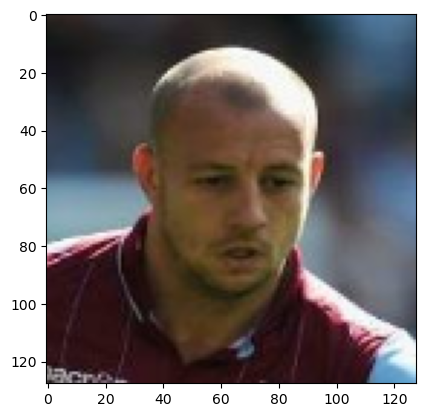

In [12]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

# path_collection = collect_images('/Users/hn/Documents/DTU/V25/Imaging/Project/1/train')
# posval, negval, posanch, neganch = make_pairs(path_collection, seed=123, n_neg_total=20000, n_pos_per_class=30)
posval, negval, posanch, neganch = make_pairs_from_folders(collect_images('/Users/hn/Documents/DTU/V25/Imaging/Project/1/train'), 30, n_neg_total=24000, n_pos_per_folder=800, seed=123)
positives = tf.data.Dataset.zip((posval, posanch, tf.data.Dataset.from_tensor_slices(tf.ones(len(posval)))))
negative = tf.data.Dataset.zip((negval, neganch, tf.data.Dataset.from_tensor_slices(tf.zeros(len(negval)))))
data = positives.concatenate(negative)
num_examples_to_see = 25

print(f"Showing the first {num_examples_to_see} positive pairs:\n")

# Use .take() to get the first 5 elements and loop through them
for i, (anchor_path, positive_path, label) in enumerate(positives.take(-num_examples_to_see)):
    print(f"--- Example {i+1} ---")
    print(f"  Anchor Path: {anchor_path.numpy().decode('utf-8')}")
    print(f"  Positive Path: {positive_path.numpy().decode('utf-8')}")
    print(f"  Label: {label.numpy()}")
    print()

print(positives.as_numpy_iterator().next())

data = data.map(preprocess_twin)
plt.imshow(data.as_numpy_iterator().next()[1])
plt.show()
data = data.cache()
data = data.shuffle(buffer_size=50000)

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(16)

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(16)


In [13]:
# train(train_data, 9)

In [14]:
# siamese_model.save('Siamese_30p_trained.keras')

In [15]:
model_path = 'Siamese_30p_trained'
custom_objects = {
    'L1Dist': L1Dist,
    # Add other custom objects here if needed
    # 'L2Dist': L2Dist,
    # 'contrastive_loss': contrastive_loss
}

# 3. Load the model with the custom objects
loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

**Trained on person identification testing**

In [16]:
all_y_true = []
all_predictions = []

for test_input, test_val, y_true in test_data:
    # Make predictions for the current batch
    predictions = siamese_model.predict([test_input, test_val])

    # Append the results
    all_y_true.append(y_true)
    all_predictions.append(predictions)



# Combine the results from all batches into single arrays
final_y_true = np.concatenate(all_y_true)
final_predictions = np.concatenate(all_predictions)

print(f"Finished processing all batches.")
print(f"Shape of final true labels: {final_y_true.shape}")
print(f"Shape of final predictions: {final_predictions.shape}")

2025-07-23 12:26:43.086056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 12975 of 50000
2025-07-23 12:26:53.089937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 25983 of 50000
2025-07-23 12:27:03.086993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 37144 of 50000
2025-07-23 12:27:13.086136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 46503 of 50000
2025-07-23 12:27:14.685401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1/1 [==============================] - 0s 405ms/step
Finished processing all batches.
Shape of final true labels: (14400,)
Shape of final predictions: (14400, 1)


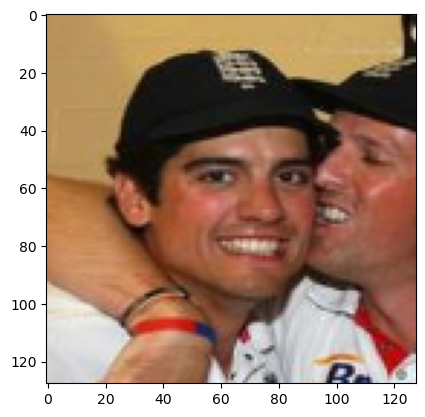

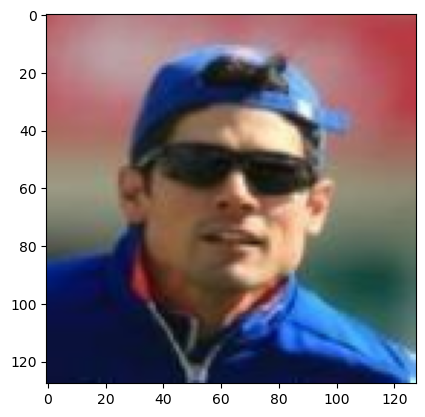

tf.Tensor([0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1.], shape=(16,), dtype=float32)
Decision Threshold (τ): 0.5
False Accept Rate (FAR): 98.92%
False Reject Rate (FRR): 0.99%


In [17]:
plt.imshow(test_input[5])
plt.show()
plt.imshow(test_val[5])
plt.show()
print(y_true)


threshold = 0.5

# 2. Separate the prediction scores for genuine and impostor pairs.
# Genuine pairs are where the true label is 1.
genuine_scores = final_predictions[final_y_true == 1]
# Impostor pairs are where the true label is 0.
impostor_scores = final_predictions[final_y_true == 0]

# 3. Calculate FP, TN, FN, TP based on the threshold.
# False Positive (False Accept): Impostor pair accepted by the model.
fp = np.sum(impostor_scores >= threshold)
# True Negative: Impostor pair correctly rejected.
tn = np.sum(impostor_scores < threshold)

# False Negative (False Reject): Genuine pair rejected by the model.
fn = np.sum(genuine_scores < threshold)
# True Positive: Genuine pair correctly accepted.
tp = np.sum(genuine_scores >= threshold)

# 4. Calculate FAR and FRR using the formulas.
# Add a small value (epsilon) to denominators to avoid division by zero.
epsilon = 1e-6
far = fp / (fp + tn + epsilon)
frr = fn / (tp + fn + epsilon)

# 5. Print the results.
print(f"Decision Threshold (τ): {threshold}")
print(f"False Accept Rate (FAR): {far:.2%}")
print(f"False Reject Rate (FRR): {frr:.2%}")

# The point where FAR and FRR are equal is called the Equal Error Rate (EER),
# which is a common metric for evaluating biometric systems.

In [18]:
predictions_squeezed = np.squeeze(final_predictions)

# 2. Convert probabilities to binary predictions (0 or 1).
binary_predictions = (predictions_squeezed > 0.5).astype(int)

# 3. Calculate accuracy. Now the shapes match perfectly.
accuracy = np.mean(binary_predictions == final_y_true)

# 4. Print the result.
print(f"Final Accuracy: {accuracy:.2%}")

Final Accuracy: 49.99%


**ONE SHOT**

Showing the first 25 positive pairs:

--- Example 1 ---
  Anchor Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/val/n001153/0174_03.jpg
  Positive Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/val/n001153/0008_01.jpg
  Label: 1.0

--- Example 2 ---
  Anchor Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/val/n001153/0015_01.jpg
  Positive Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/val/n001153/0193_02.jpg
  Label: 1.0

--- Example 3 ---
  Anchor Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/val/n001153/0082_02.jpg
  Positive Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/val/n001153/0186_01.jpg
  Label: 1.0

--- Example 4 ---
  Anchor Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/val/n001153/0010_01.jpg
  Positive Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/val/n001153/0238_02.jpg
  Label: 1.0

--- Example 5 ---
  Anchor Path: /Users/hn/Documents/DTU/V25/Imaging/Project/1/val/n001153/0205_01.jpg
  Positive Path: /Users/hn/Documents/DTU/V2

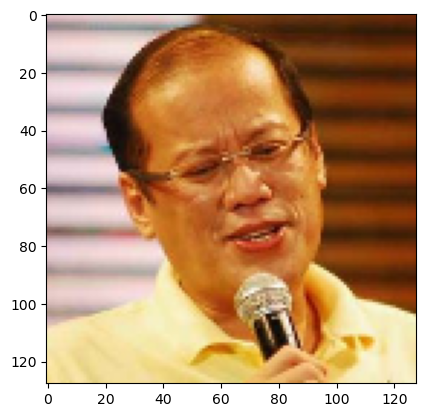

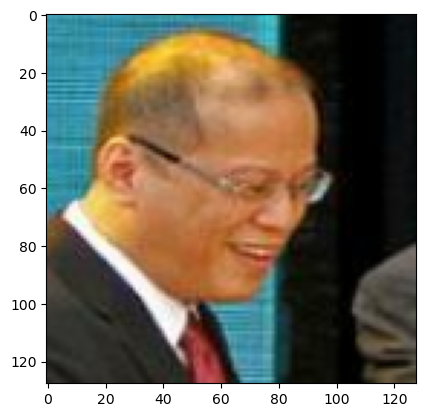

tf.Tensor([1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.], shape=(16,), dtype=float32)
Finished processing all batches.
Shape of final true labels: (2400,)
Shape of final predictions: (2400, 1)


In [19]:
posval, negval, posanch, neganch = make_pairs_from_folders(collect_images('/Users/hn/Documents/DTU/V25/Imaging/Project/1/val'), 50, n_neg_total=3000, n_pos_per_folder=100, seed=124)
positives = tf.data.Dataset.zip((posval, posanch, tf.data.Dataset.from_tensor_slices(tf.ones(len(posval)))))
negative = tf.data.Dataset.zip((negval, neganch, tf.data.Dataset.from_tensor_slices(tf.zeros(len(negval)))))
data1 = positives.concatenate(negative)
num_examples_to_see = 25

print(f"Showing the first {num_examples_to_see} positive pairs:\n")

# Use .take() to get the first 5 elements and loop through them
for i, (anchor_path, positive_path, label) in enumerate(positives.take(-num_examples_to_see)):
    print(f"--- Example {i+1} ---")
    print(f"  Anchor Path: {anchor_path.numpy().decode('utf-8')}")
    print(f"  Positive Path: {positive_path.numpy().decode('utf-8')}")
    print(f"  Label: {label.numpy()}")
    print()

print(positives.as_numpy_iterator().next())

data1 = data1.map(preprocess_twin)

data1 = data1.cache()
data1 = data1.shuffle(buffer_size=20000)

train_data1 = data1.take(round(len(data1)*.7))
train_data1 = train_data1.batch(16)
train_data1 = train_data1.prefetch(16)

test_data1 = data1.skip(round(len(data1)*.7))
test_data1 = test_data1.take(round(len(data1)*.3))
test_data1 = test_data1.batch(16)
test_data1 = test_data1.prefetch(16)
print(test_data1)


all_y_true = []
all_predictions = []

# Loop directly over the dataset
# This will process every batch until the dataset is exhausted.
for test_input, test_val, y_true in test_data1:
    # Make predictions for the current batch
    predictions = siamese_model.predict([test_input, test_val])

    # Append the results
    all_y_true.append(y_true)
    all_predictions.append(predictions)

plt.imshow(test_input[1])
plt.show()
plt.imshow(test_val[1])
plt.show()
print(y_true)

# Combine the results from all batches into single arrays
final_y_true = np.concatenate(all_y_true)
final_predictions = np.concatenate(all_predictions)

print(f"Finished processing all batches.")
print(f"Shape of final true labels: {final_y_true.shape}")
print(f"Shape of final predictions: {final_predictions.shape}")

In [20]:
predictions_squeezed = np.squeeze(final_predictions)

# 2. Convert probabilities to binary predictions (0 or 1).
binary_predictions = (predictions_squeezed > 0.5).astype(int)

# 3. Calculate accuracy. Now the shapes match perfectly.
accuracy = np.mean(binary_predictions == final_y_true)

# 4. Print the result.
print(f"Final Accuracy: {accuracy:.2%}")

Final Accuracy: 62.25%


In [21]:
# 1. Define your decision threshold (tau). 0.5 is a standard starting point.
threshold = 0.5

# 2. Separate the prediction scores for genuine and impostor pairs.
# Genuine pairs are where the true label is 1.
genuine_scores = final_predictions[final_y_true == 1]
# Impostor pairs are where the true label is 0.
impostor_scores = final_predictions[final_y_true == 0]

# 3. Calculate FP, TN, FN, TP based on the threshold.
# False Positive (False Accept): Impostor pair accepted by the model.
fp = np.sum(impostor_scores >= threshold)
# True Negative: Impostor pair correctly rejected.
tn = np.sum(impostor_scores < threshold)

# False Negative (False Reject): Genuine pair rejected by the model.
fn = np.sum(genuine_scores < threshold)
# True Positive: Genuine pair correctly accepted.
tp = np.sum(genuine_scores >= threshold)

# 4. Calculate FAR and FRR using the formulas.
# Add a small value (epsilon) to denominators to avoid division by zero.
epsilon = 1e-6
far = fp / (fp + tn + epsilon)
frr = fn / (tp + fn + epsilon)

# 5. Print the results.
print(f"Decision Threshold (τ): {threshold}")
print(f"False Accept Rate (FAR): {far:.2%}")
print(f"False Reject Rate (FRR): {frr:.2%}")

# The point where FAR and FRR are equal is called the Equal Error Rate (EER),
# which is a common metric for evaluating biometric systems.


Decision Threshold (τ): 0.5
False Accept Rate (FAR): 98.67%
False Reject Rate (FRR): 1.20%


**Different distance check**

In [22]:
# # No changes needed for the L1Dist layer, but we'll create an L2 version for this
# class L2Dist(Layer):
#     def __init__(self, **kwargs):
#         super().__init__()
       
#     def call(self, input_embedding, validation_embedding):
#         # Calculate the L2 (Euclidean) distance
#         return tf.sqrt(tf.reduce_sum(tf.square(input_embedding - validation_embedding), axis=1, keepdims=True))

# def make_siamese_model_contrastive(): 
#     input_image = Input(name='input_img', shape=(128, 128, 3))
#     validation_image = Input(name='validation_img', shape=(128, 128, 3))
    
#     # Get the shared embedding model
#     embedding_model = make_embedding() # Use your existing embedding model
    
#     # Calculate the distance between the two embeddings
#     distance_layer = L2Dist()
#     distances = distance_layer(embedding_model(input_image), embedding_model(validation_image))
    
#     # The model now outputs the distance directly
#     return Model(inputs=[input_image, validation_image], outputs=distances, name='SiameseNetworkContrastive')

# # Create the new model
# siamese_model = make_siamese_model_contrastive()

# # Define the margin for contrastive loss
# MARGIN = 1.0

# def contrastive_loss(y_true, y_pred):
#     """
#     y_true: label (1 for positive, 0 for negative)
#     y_pred: predicted distance between embeddings
#     """
#     y_true = tf.cast(y_true, y_pred.dtype)
    
#     # Loss for positive pairs
#     square_pred = tf.square(y_pred)
    
#     # Loss for negative pairs
#     margin_square = tf.square(tf.maximum(MARGIN - y_pred, 0))
    
#     return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

# # Your new train_step
# @tf.function
# def train_step(batch):
#     with tf.GradientTape() as tape:     
#         X = [batch[0], batch[1]]
#         y = batch[2]
        
#         # Get the predicted distances
#         yhat_distances = siamese_model(X, training=True)
        
#         # Calculate loss using the new function
#         loss = contrastive_loss(y, yhat_distances)
        
#     grad = tape.gradient(loss, siamese_model.trainable_variables)
#     opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
#     return loss, yhat_distances

# def train(data, EPOCHS):
#     for epoch in range(1, EPOCHS + 1):
#         print(f"\nEpoch {epoch}/{EPOCHS}")
#         progbar = tf.keras.utils.Progbar(len(data))
        
#         # Lists to store distances for the entire epoch
#         epoch_pos_dists = []
#         epoch_neg_dists = []

#         # Loop through each batch
#         for idx, batch in enumerate(data):
#             # 1. Run train_step, which now returns both loss and distances
#             loss, yhat_distances = train_step(batch)
            
#             # 2. Get the true labels for the current batch
#             y_true = batch[2]

#             # 3. Create boolean masks to identify positive and negative pairs
#             pos_mask = tf.cast(y_true, dtype=tf.bool)
#             neg_mask = tf.logical_not(pos_mask)

#             # --- THE FIX IS HERE ---
#             # 4. Safely extract and flatten the distances before extending the lists
            
#             # Select distances for positive pairs and flatten to a 1D tensor
#             pos_batch_dists = tf.reshape(tf.boolean_mask(yhat_distances, pos_mask), [-1])
#             # Select distances for negative pairs and flatten to a 1D tensor
#             neg_batch_dists = tf.reshape(tf.boolean_mask(yhat_distances, neg_mask), [-1])

#             # 5. Extend the epoch lists with the flattened batch distances
#             epoch_pos_dists.extend(pos_batch_dists)
#             epoch_neg_dists.extend(neg_batch_dists)
#             # --- END FIX ---

#             progbar.update(idx + 1, [('loss', loss)])

#         # Calculate and print the average distances
#         avg_pos_dist = tf.reduce_mean(epoch_pos_dists) if epoch_pos_dists else 0.0
#         avg_neg_dist = tf.reduce_mean(epoch_neg_dists) if epoch_neg_dists else 0.0

#         print(f"Epoch {epoch} Summary:")
#         print(f"  Loss: {loss.numpy():.4f}")
#         print(f"  Avg Pos Dist: {avg_pos_dist:.4f} ⬇️ (should decrease)")
#         print(f"  Avg Neg Dist: {avg_neg_dist:.4f} ⬆️ (should increase towards margin)")
        
#         if epoch % 10 == 0: 
#             checkpoint.save(file_prefix=checkpoint_prefix)

In [23]:
#train(train_data, 20)

In [24]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 402ms/step


array([[0.50186676],
       [0.5033342 ],
       [0.50256026],
       [0.50245345],
       [0.5047332 ],
       [0.50186706],
       [0.5038594 ],
       [0.5006457 ],
       [0.5037972 ],
       [0.50553966],
       [0.5005629 ],
       [0.5012484 ],
       [0.5007893 ],
       [0.5039421 ],
       [0.50110066],
       [0.50168735]], dtype=float32)